<a href="https://colab.research.google.com/github/i-m-vivek/deep-learning-mini_projects/blob/master/VGG_MET_Image_Jigsaw_Solver_with_Transformer_3_3_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# i = 0
# l = []
# while (True):
#     l.append(i)
#     i+=1

In [ ]:
!nvidia-smi

Tue Jun  9 05:10:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# !unzip "/content/drive/My Drive/Image Jigsaw Dataset/data_kept.zip"
# this dataset is not so good
# !unrar x "/content/drive/My Drive/Image Jigsaw Dataset/Caltech256_3-3_premuted_images.rar"
!unrar x "/content/drive/My Drive/MET Dataset/met_permuted.rar"

In [ ]:
import torch 
import cv2 as cv
import torch.nn.functional as F
from torch import nn 
from torch.utils import data as torch_data 
from torchvision import models, transforms
import torchvision

from tqdm import tqdm_notebook
from PIL import Image
import pandas as pd
import numpy as np 
import os 
import time
import copy
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [ ]:
class JigsawDataset(torch_data.Dataset):
    """Dataset for Jigsaw Solving Task for 2*2 peices Images. 
    The Dataset will output a Image and 4 Numbers corresponding to the position of the peices."""

    def __init__(self, df, root_dir, transform):
        """
        Args: 
            df (pd.DataFrame): DataFrame with positions.
            root_dir (string): Path to the dir. where all images are present.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.df = df
        self.root_dir = root_dir
        self.transform = transform 

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = str(self.df.iloc[idx, 0])
        # img = Image.open(os.path.join(self.root_dir, img_name))
        img = cv.imread(os.path.join(self.root_dir, img_name))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        img = img.resize((350, 350), resample= Image.BILINEAR)
        d = {"img": img}
        for i in range(1, 10):
            d["perm"+str(i)] = perm = self.df.iloc[idx, i]

        if self.transform is not None:
            d["img"] = self.transform(img)

        return d

In [ ]:
composed_transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])
#    transforms.RandomErasing(.3, )])

In [ ]:
train = pd.read_csv("/content/drive/My Drive/MET Dataset/met_permuted.csv")

In [ ]:
train = train.iloc[:, 1:]
train.head()

,img_name,1,2,3,4,5,6,7,8,9
0,00011f01965f141f5d1eea6592fa9862.png,7,8,5,2,3,0,1,6,4
1,00014abc91ed3e4bf1663fde8136fe80.png,8,2,0,4,1,5,7,3,6
2,0002e2054e303badc1a33463f6fb7973.png,4,6,1,8,5,2,3,0,7
3,0002e8f35f85f28bebfb28f2a627dc4d.png,2,8,6,1,7,0,4,5,3
4,00082dfc0de78506f96104bc05eb5a49.png,7,3,1,8,5,4,0,2,6


In [ ]:
X_train, X_val = train_test_split(train, test_size= .2, random_state = 42, shuffle= True)

In [ ]:
img_dir_path = "/content/met_permuted"
train_dataset = JigsawDataset(df = X_train,
                                           root_dir=img_dir_path,
                                           transform=composed_transform)
val_dataset = JigsawDataset(df = X_val, 
                                           root_dir=img_dir_path,
                                           transform=composed_transform)

In [ ]:
trainloader = torch_data.DataLoader(train_dataset, batch_size= 32, shuffle=True)
valloader = torch_data.DataLoader(val_dataset, batch_size= 32, shuffle=False)

dataloaders = {"train": trainloader, 
               "val": valloader}
dataset_sizes = {"train":  len(train_dataset), 
                 "val": len(val_dataset)}

In [ ]:
dataset_sizes

{'train': 20766, 'val': 5192}

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

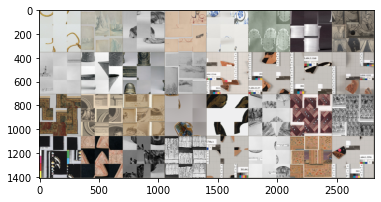

In [ ]:
sample = next(iter(trainloader))
out = torchvision.utils.make_grid(sample["img"])
imshow(out)

In [ ]:
sample

{'img': tensor([[[[ 0.7762,  0.8104,  0.7762,  ...,  1.5810,  1.5810,  1.5810],
           [ 0.7419,  0.9474,  0.8618,  ...,  1.5982,  1.5810,  1.5810],
           [ 0.8276,  0.9646,  0.8961,  ...,  1.5982,  1.5810,  1.5810],
           ...,
           [ 1.5810,  1.5639,  1.5810,  ...,  1.5468,  1.5468,  1.5639],
           [ 1.5982,  1.5810,  1.5810,  ...,  1.5639,  1.5639,  1.5639],
           [ 1.5468,  1.5639,  1.5468,  ...,  1.5639,  1.5468,  1.5639]],
 
          [[ 0.3452,  0.3978,  0.3627,  ...,  1.8158,  1.8158,  1.8158],
           [ 0.3452,  0.6254,  0.5203,  ...,  1.8333,  1.8158,  1.8158],
           [ 0.4153,  0.5903,  0.5028,  ...,  1.8508,  1.8333,  1.8158],
           ...,
           [ 1.8508,  1.8333,  1.8508,  ...,  1.7458,  1.7458,  1.7633],
           [ 1.8683,  1.8508,  1.8508,  ...,  1.7633,  1.7633,  1.7633],
           [ 1.8158,  1.8333,  1.8158,  ...,  1.7458,  1.7283,  1.7633]],
 
          [[-0.5495, -0.5321, -0.6018,  ...,  2.0474,  2.0474,  2.0474],
      

In [ ]:

# transformed_dataset = JigsawDataset(csv_file="/content/drive/My Drive/Image Jigsaw Dataset/data_kept_50000.csv",
#                                            root_dir='/content/data_kept/',
#                                            transform=composed_transform)
# for i in range(len(transformed_dataset)):
#     sample = transformed_dataset[i]

#     print(i, sample['img'].size(), sample["perm1"], sample["perm2"], sample["perm3"], sample["perm4"])

#     if i == 3:
#         break

## Transformer

In [ ]:
def clones(module, N):
    "Produce N identical layers. The Transformer Enlayer "
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    """
    Input shape of q,k,v is (nbatches, self.h, -1, self.d_k) 
    here -1 means the len of the given sequence
    """
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout= 0.1):
        super(MultiHeadedAttention, self).__init__()

        assert d_model %h ==0

        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p= dropout)

    def forward(self, query, key, value):

        nbatches = query.size(0)
        query, key, value = \
        [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) 
        for l, x in zip(self.linears, (query, key, value))]

        # shape of x => (nbatches, self.h, -1, self.d_k) 
        x, self.attn = attention(query, key, value, dropout=self.dropout)

        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        # now shape of x is (nbatches,  -1, self.h*self.d_k)

        return self.linears[-1](x) # remember we made 4 layers.

class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x))
        return self.sublayer[1](x, self.feed_forward)

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

In [ ]:
from torch.autograd import Variable

class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        x = self.dropout(x)
        return x

In [ ]:

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.vgg = torchvision.models.vgg16_bn(pretrained=True)
        self.vgg.avgpool = nn.AdaptiveAvgPool2d(output_size=(3, 3))
        modules  = list(self.vgg.children())[:-1]
        self.vgg = nn.Sequential(*modules)


    def forward(self, x):
        m = x.size(0) #batch_size
        x = self.vgg(x)
        x = x.view(m, -1, 512) #shape (m, 9, 512)
        return x

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(512, 9)
        self.fc2 = nn.Linear(512, 9)
        self.fc3 = nn.Linear(512, 9)
        self.fc4 = nn.Linear(512, 9)
        self.fc5 = nn.Linear(512, 9)
        self.fc6 = nn.Linear(512, 9)
        self.fc7 = nn.Linear(512, 9)
        self.fc8 = nn.Linear(512, 9)
        self.fc9 = nn.Linear(512, 9)

    def forward(self, x):
        x1 = self.fc1(x[:, 0,:])
        x2 = self.fc2(x[:, 1,:])
        x3 = self.fc3(x[:, 2,:])
        x4 = self.fc4(x[:, 3,:])
        x5 = self.fc5(x[:, 4,:])
        x6 = self.fc6(x[:, 5,:])
        x7 = self.fc7(x[:, 6,:])
        x8 = self.fc8(x[:, 7,:])
        x9 = self.fc9(x[:, 8,:])
        return x1, x2, x3, x4, x5, x6, x7, x8, x9

**Pipeline** : VGG --- Positional Encoding --- Transformer --- Classifier

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# VGG
vgg = VGG().to(device)

# positional Encoding 
position = PositionalEncoding(512, .1, 9).to(device)

# Transformer 
h = 8
d_model = 512
d_ff = 2048
dropout= .1
c = copy.deepcopy
attn = MultiHeadedAttention(h, d_model)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
transformer = Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), 1).to(device)

# Classifier
classifier = Classifier().to(device)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [ ]:
# from torchsummary import summary
# summary(net, (3, 351, 450))

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
vgg_optim = optim.Adam(vgg.parameters(), lr= .0001)
transformer_optim = optim.Adam(transformer.parameters(), lr= .001)
classifier_optim = optim.Adam(classifier.parameters(), lr= .001)

In [ ]:
def train_model(vgg, position, transformer, classifier, criterion, vgg_optim, transformer_optim, classifier_optim, num_epochs=25):
    since = time.time()

    vgg_best_model_wts = copy.deepcopy(vgg.state_dict())
    transformer_best_model_wts = copy.deepcopy(transformer.state_dict())
    classifier_best_model_wts = copy.deepcopy(classifier.state_dict())
    running_loss_arr = []
    running_acc_arr = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                vgg.train()  # Set model to training mode
                transformer.train()
                classifier.train()

            else:
                vgg.eval()   # Set model to evaluate mode
                transformer.eval()
                classifier.eval()
                
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inp_data in tqdm_notebook(dataloaders[phase]):
                inputs = inp_data["img"].to(device)

                label1 = inp_data["perm1"].to(device)
                label2 = inp_data["perm2"].to(device)
                label3 = inp_data["perm3"].to(device)
                label4 = inp_data["perm4"].to(device)
                label5 = inp_data["perm5"].to(device)
                label6 = inp_data["perm6"].to(device)
                label7 = inp_data["perm7"].to(device)
                label8 = inp_data["perm8"].to(device)
                label9 = inp_data["perm9"].to(device)

                # zero the parameter gradients
                classifier_optim.zero_grad()
                transformer_optim.zero_grad()
                vgg_optim.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    vgg_out = vgg(inputs)
                    position_out = position(vgg_out)
                    transformer_out = transformer(position_out)
                    out1, out2, out3, out4, out5, out6, out7, out8, out9 = classifier(transformer_out)
                    _, preds1 = torch.max(out1, 1)
                    _, preds2 = torch.max(out2, 1)
                    _, preds3 = torch.max(out3, 1)
                    _, preds4 = torch.max(out4, 1)
                    _, preds5 = torch.max(out5, 1)
                    _, preds6 = torch.max(out6, 1)
                    _, preds7 = torch.max(out7, 1)
                    _, preds8 = torch.max(out8, 1)
                    _, preds9 = torch.max(out9, 1)

                    loss = criterion(out1, label1.long()) + criterion(out2, label2.long()) + criterion(out3, label3.long()) + criterion(out4, label4.long()) + criterion(out5, label5.long()) + criterion(out6, label6.long()) + criterion(out7, label7.long()) + criterion(out8, label8.long()) + criterion(out9, label9.long())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        classifier_optim.step()
                        transformer_optim.step()
                        vgg_optim.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_loss_arr.append(loss.item())
                running_corrects += (torch.sum(preds1 == label1.data) + torch.sum(preds2 == label2.data) + torch.sum(preds3 == label3.data)+ torch.sum(preds4 == label4.data) +  torch.sum(preds5 == label5.data) + torch.sum(preds6 == label6.data)+ torch.sum(preds7 == label7.data)+ torch.sum(preds8 == label8.data)+ torch.sum(preds9 == label9.data))/9
                running_acc_arr.append(running_corrects/(inputs.size(0)))
            # if phase == 'train':
            #     scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                vgg_best_model_wts = copy.deepcopy(vgg.state_dict())
                transformer_best_model_wts = copy.deepcopy(transformer.state_dict())
                classifier_best_model_wts = copy.deepcopy(classifier.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    vgg.load_state_dict(vgg_best_model_wts)
    transformer.load_state_dict(transformer_best_model_wts)
    classifier.load_state_dict(classifier_best_model_wts)

    return vgg, position, transformer, classifier, running_loss_arr, running_acc_arr

In [ ]:
vgg, position, transformer, classifier, running_loss_arr, running_acc_arr = train_model(vgg, position, transformer, classifier, criterion, vgg_optim, transformer_optim, classifier_optim, num_epochs=10)
# model_ft, running_loss_arr, running_acc_arr = train_model(model_ft, criterion, optimizer, num_epochs=5)

Epoch 0/9
----------



train Loss: 11.8579 Acc: 0.4936



val Loss: 4.3085 Acc: 0.8295

Epoch 1/9
----------



train Loss: 3.5790 Acc: 0.8560



val Loss: 3.1840 Acc: 0.8686

Epoch 2/9
----------



train Loss: 2.4802 Acc: 0.8945



val Loss: 2.7578 Acc: 0.8842

Epoch 3/9
----------



train Loss: 1.8866 Acc: 0.9153



val Loss: 2.7289 Acc: 0.8891

Epoch 4/9
----------



train Loss: 1.4484 Acc: 0.9315



val Loss: 2.6793 Acc: 0.8943

Epoch 5/9
----------



train Loss: 1.1358 Acc: 0.9430



val Loss: 2.9953 Acc: 0.8921

Epoch 6/9
----------



train Loss: 0.9426 Acc: 0.9507



val Loss: 3.0699 Acc: 0.8941

Epoch 7/9
----------



train Loss: 0.7404 Acc: 0.9583



val Loss: 3.4266 Acc: 0.8931

Epoch 8/9
----------



train Loss: 0.6608 Acc: 0.9611



val Loss: 3.1534 Acc: 0.8987

Epoch 9/9
----------



train Loss: 0.5656 Acc: 0.9637



val Loss: 3.2837 Acc: 0.8985

Training complete in 360m 17s
Best val Acc: 0.898690


In [ ]:
torch.save({
    "Epoch": 10, 
    "Dataset": "MET Dataset", 
    "Model": "VGG + Transformer", 
    "vgg": vgg.state_dict(), 
    "transformer": transformer.state_dict(),
    "position": position.state_dict(), 
    "classifier": classifier.state_dict(), 
    "vgg_optimizer":vgg_optim.state_dict() ,
    "transformer_optimizer":transformer_optim.state_dict() ,
    "classifier_optimizer":classifier_optim.state_dict() ,
}, "/content/drive/My Drive/MET Dataset/checkpoint_vgg_with_transformer_10epochs.pth")

In [ ]:
torch.save({
    "Epoch": 10, 
    "Dataset": "MET Dataset", 
    "Model": "VGG + Transformer", 
    "vgg": vgg.state_dict(), 
    "transformer": transformer.state_dict(),
    "position": position.state_dict(), 
    "classifier": classifier.state_dict(), 
    "vgg_optimizer":vgg_optim.state_dict() ,
    "transformer_optimizer":transformer_optim.state_dict() ,
    "classifier_optimizer":classifier_optim.state_dict() ,
}, "/content/drive/My Drive/MET Dataset/checkpoint_vgg_with_transformer_10epochs.pth")

In [ ]:
np_loss, np_acc = np.array(running_loss_arr), np.array(running_acc_arr)

In [ ]:
torch.save(vgg.state_dict(), "/content/drive/My Drive/Image Jigsaw Dataset/vgg_for_3-3_transformer_15epochs.pth")
torch.save(transformer.state_dict(), "/content/drive/My Drive/Image Jigsaw Dataset/transformer_for_3-3_transformer_15epochs.pth")
torch.save(position.state_dict(), "/content/drive/My Drive/Image Jigsaw Dataset/position_for_3-3_transformer_15epochs.pth")
torch.save(classifier.state_dict(), "/content/drive/My Drive/Image Jigsaw Dataset/classifier_for_3-3_transformer_15epochs.pth")

# vgg, transformer, classifier

In [ ]:
np.save("/content/drive/My Drive/Image Jigsaw Dataset/loss_for_3-3_transformer_5epochs-last5epochs.npy", np_loss)
np.save("/content/drive/My Drive/Image Jigsaw Dataset/acc_for_3-3_transformer_5epochs-last5epochs.npy", np_acc)

In [ ]:
# for 5 epochs the val acc was around 50%
# Needs to be greater than 80% atleast

## Some Testing

In [ ]:
sample_loader = torch_data.DataLoader(val_dataset, batch_size= 1, shuffle=True)
sample_iter = iter(sample_loader)

[7, 2, 0, 3, 5, 1, 6, 8, 4]
[7, 2, 0, 3, 5, 1, 6, 8, 4]


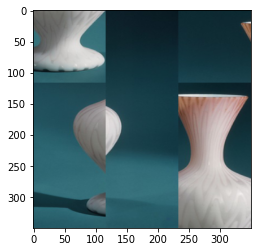

In [ ]:
sample_data = next(sample_iter)
imshow(sample_data["img"].squeeze(0))
print([sample_data["perm1"].numpy()[0], sample_data["perm2"].numpy()[0], sample_data["perm3"].numpy()[0], sample_data["perm4"].numpy()[0], sample_data["perm5"].numpy()[0], sample_data["perm6"].numpy()[0], sample_data["perm7"].numpy()[0], sample_data["perm8"].numpy()[0], sample_data["perm9"].numpy()[0]])

vgg_out = vgg(sample_data["img"].to(device))
position_out = position(vgg_out)
transformer_out = transformer(position_out)
sample_preds= classifier(transformer_out)
sample_preds_list = []
for i in range(9):
    _, sample_preds_ = torch.max((sample_preds[i]), 1)
    sample_preds_list.append(sample_preds_.detach().cpu().numpy()[0])

print(sample_preds_list)

In [ ]:
sample_data["img"].squeeze(0).shape

torch.Size([3, 350, 350])

In [ ]:
sample_data

{'img': tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           ...,
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
          [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           ...,
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
          [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
           [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
           [2.640

In [ ]:
# sample_preds = model_ft(sample_data["img"].to(device))
sample_vgg_out = vgg(sample_data["img"].to(device))
sample_position_out = position(sample_vgg_out)
sample_transformer_out = transformer(sample_position_out)
sample_preds = classifier(sample_transformer_out)

In [ ]:
sample_preds_list = []
for i in range(9):
    _, sample_preds_ = torch.max((sample_preds[i]), 1)
    sample_preds_list.append(sample_preds_)

In [ ]:
# sample_preds_
#  'perm5': tensor([1, 1, 2, 3]),

In [ ]:
sample_preds_list

[tensor([0], device='cuda:0'),
 tensor([8], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([7], device='cuda:0'),
 tensor([7], device='cuda:0'),
 tensor([6], device='cuda:0'),
 tensor([4], device='cuda:0'),
 tensor([4], device='cuda:0'),
 tensor([8], device='cuda:0')]

In [ ]:
# perm1': tensor([8]),
#  'perm2': tensor([6]),
#  'perm3': tensor([0]),
#  'perm4': tensor([5]),
#  'perm5': tensor([2]),
#  'perm6': tensor([4]),
#  'perm7': tensor([1]),
#  'perm8': tensor([7]),
#  'perm9': tensor([3])}

In [ ]:
sample_data["img"][0].shape

torch.Size([3, 255, 255])

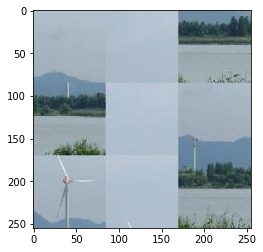

In [ ]:
imshow(sample_data["img"][0])

In [ ]:
# 'perm1': tensor([0]),
#  'perm2': tensor([6]),
#  'perm3': tensor([8]),
#  'perm4': tensor([3]),
#  'perm5': tensor([1]),
#  'perm6': tensor([5]),
#  'perm7': tensor([2]),
#  'perm8': tensor([7]),
#  'perm9': tensor([4])}